## Import libraries

In [23]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns
import random
import torch.nn.functional as F

## Download and Preprocess Dataset

In [24]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

num_classes = 10

## Preprocessing

In [25]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

## Prepare the data

In [26]:
# function for adding some more data from other classes
def put_salt(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    np.random.shuffle(image_indices)
    image_indices = image_indices[:image_indices.shape[0] // 5 + 1]
    original_images = source_dataset_images[image_indices] # get the original images
    negative_images = invert(original_images)
    for i in range(len(original_images)):
      flattened_image = original_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.8:
          flattened_image[j] = 1
      original_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,original_images))
    for i in range(len(negative_images)):
      flattened_image = negative_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.2:
          flattened_image[j] = 1
      negative_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,negative_images))
    return target_dataset

def put_pepper(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    np.random.shuffle(image_indices)
    image_indices = image_indices[:image_indices.shape[0] // 5 + 1]
    original_images = source_dataset_images[image_indices] # get the original images
    negative_images = invert(original_images)
    for i in range(len(original_images)):
      flattened_image = original_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.8:
          flattened_image[j] = 0
      original_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,original_images))
    for i in range(len(negative_images)):
      flattened_image = negative_images[i].flatten()
      for j in range(len(flattened_image)):
        p = random.uniform(0,1)
        if p <= 0.8:
          flattened_image[j] = 0
      negative_images[i] = np.reshape(flattened_image,(28,28))
    target_dataset = np.concatenate((target_dataset,negative_images))
    return target_dataset

def get_inverted_data(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    image_indices = np.asarray(np.where(source_dataset_labels == class_num))
    image_indices = image_indices.flatten()
    np.random.shuffle(image_indices)
    image_indices = image_indices[:image_indices.shape[0] // 5 + 1]
    original_images = invert(source_dataset_images[image_indices]) # get the original images
    target_dataset = np.concatenate((target_dataset,original_images))
    return target_dataset

def generate_labels(dataset_images,images_type):
  labels = np.zeros((dataset_images.shape[0],2))
  # for i,image in enumerate(dataset_images):
  #   labels[i][images_type] = np.sum(dataset_images[i]) / 784
  labels = np.full(shape=(dataset_images.shape[0],2),fill_value=[1-images_type,images_type],dtype=np.float32)
  return labels

# function to prepare the dataset for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num):
    indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    indices = indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0)
    print(dataset_images_positive.shape)
    # get the images for making negative dataset
    # dataset_images_negative = invert(dataset_images_positive) # inverted images
    dataset_images_negative = np.empty((0,28,28),dtype=np.float32)
    dataset_images_negative = put_salt(dataset_images,dataset_labels,dataset_images_negative,class_num)
    dataset_images_negative = put_pepper(dataset_images,dataset_labels,dataset_images_negative,class_num)
    dataset_images_negative = get_inverted_data(dataset_images,dataset_labels,dataset_images_negative,class_num)
    print(dataset_images_negative.shape)

    # negative_data_indices = [i for i in range(len(dataset_labels)) if i not in indices]
    # dataset_images_negative = dataset_images[negative_data_indices]
    
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

def concat_datasets(dataset1_images,dataset1_labels,dataset2_images,dataset2_labels,class_num):
    # join the two datasets
    joined_dataset_images = np.concatenate((dataset1_images,dataset2_images))
    joined_dataset_labels = np.concatenate((dataset1_labels,dataset2_labels))
    
    indices = np.asarray(np.where(joined_dataset_labels == class_num)) # indices of occurrence of class as label
    indices = indices.flatten()
    dataset_images_positive = joined_dataset_images[indices] # images consisting of positive class
    print(dataset_images_positive.shape)
    dataset_labels_positive = generate_labels(dataset_images_positive,0)
    negative_data_indices = [i for i in range(len(joined_dataset_labels)) if i not in indices]
    
    dataset_images_negative = joined_dataset_images[negative_data_indices]
    dataset_images_negative = dataset_images_negative[:6876]
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    print(dataset_images_negative.shape)
    
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))

    
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

### Plotting some data

(5918, 28, 28)
(5920, 28, 28)
(6876, 28, 28)
(6876, 28, 28)


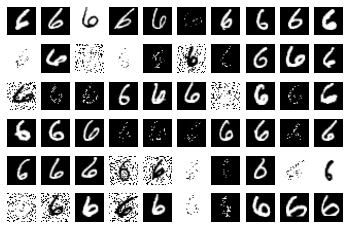

In [27]:
class_num = 6
train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
test_class_set = concat_datasets(train_images,train_labels,test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=64,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=64,shuffle=True) # take original testing set of all classes
dataiter = iter(train_loader)
images,labels = dataiter.next()
figure = plt.figure()
# print(labels)
num_of_images = 60  
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [28]:
def softmax(output):
  return torch.exp(output) / torch.sum(torch.exp(output),dim=1).view(-1,1)

# Model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)  # 4*4 from image dimension
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

epochs = 10
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)

# function to train the model

model.train()
for e in range(epochs):
  running_loss = 0.0
  for batch, (images,logits) in enumerate(train_loader):
    optimizer.zero_grad()
    # compute prediction error
    output = model(images)
    loss = criterion(output,logits)

    # Backpropagation
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  else:
    print(f"Training loss: {running_loss/len(train_loader)}")


Training loss: 0.5825504549451777
Training loss: 0.2865018235670554
Training loss: 0.11509177225667078
Training loss: 0.07049372915077853
Training loss: 0.05116597266011947
Training loss: 0.039018170792307405
Training loss: 0.031354303426436476
Training loss: 0.025839377320497424
Training loss: 0.021811711561639566
Training loss: 0.01856425820623298


### Testing without threshold

In [29]:
# function to test the model
def test(dataloader,model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    with torch.no_grad():
        for images,logits in dataloader:
            output = model(images)
            output = softmax(output)
            correct += (output.argmax(1) == logits.argmax(1)).type(torch.float).sum().item()
    correct /= size
    print(f"Accuracy : {(100*correct):>0.1f}%")

test(test_loader,model)
data = np.empty((0,3),dtype=np.float32)

with torch.no_grad():
    for images,scores in test_loader:
      output = model(images)
      output = softmax(output)
      output = output.numpy()
      scores = scores.numpy()
      for i in range(len(output)):
        yes_score = output[i][0]
        no_score = output[i][1]
        true_label =  1 if np.argmax(scores[i]) == 0 else 0 
        if true_label == 0:
          data = np.vstack((data,[[yes_score,no_score,true_label]]))
df = pd.DataFrame(data)
df.columns = ['yes_score','no_score','true_label']
df.describe()

Accuracy : 56.7%


,yes_score,no_score,true_label
count,6876.000000,6876.000000,6876.0
mean,0.828132,0.171868,0.0
std,0.261141,0.261141,0.0
min,0.001890,0.000148,0.0
25%,0.776154,0.007007,0.0
50%,0.966852,0.033148,0.0
75%,0.992993,0.223846,0.0
max,0.999852,0.998110,0.0


         yes_score     no_score  true_label
count  6876.000000  6876.000000      6876.0
mean      0.828132     0.171868         0.0
std       0.261141     0.261141         0.0
min       0.001890     0.000148         0.0
25%       0.776154     0.007007         0.0
50%       0.966852     0.033148         0.0
75%       0.992993     0.223846         0.0
max       0.999852     0.998110         0.0


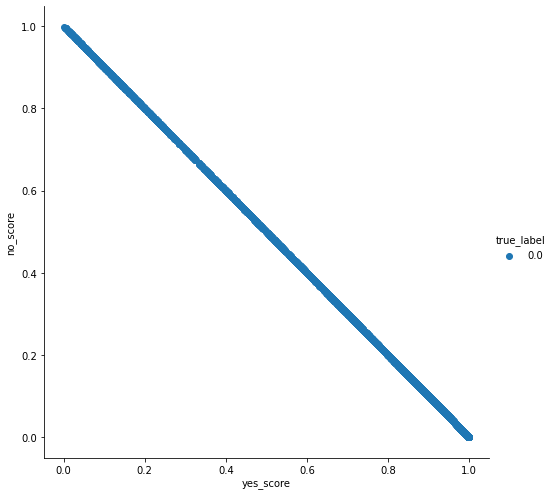

In [30]:
print(df.describe())
sns.FacetGrid(df,hue="true_label",height=7).map(plt.scatter,"yes_score","no_score").add_legend()
plt.show()

## Testing

In [31]:
# function to test the model on a given threshold
def test_with_threshold(dataloader,model,threshold):
  size = len(dataloader.dataset)
  model.eval()
  accuracy = 0
  y_true = [] # store the true class
  y_pred = [] # store the predicted class
  y_pred_score = []
  y_true_score = []
  with torch.no_grad():
      for images,logits in dataloader:
        output = model(images)
        output = softmax(output)
        outnp = output.numpy()
        logit_np = logits.numpy()
        for i in range(len(outnp)):
          true_label = 1 if logit_np[i][0] >= logit_np[i][1] else 0 # true class
          y_true.append(true_label)
          y_true_score.append(logit_np[i][0]) # true yes score
          y_pred_score.append(outnp[i][0]) # predicted yes score
          if outnp[i][0] >= threshold:
            y_pred.append(1) # predicted positive class
          else:
            y_pred.append(0) # predicted negative class
  accuracy = accuracy_score(y_true,y_pred) # calculate the accuracy
  precision = precision_score(y_true,y_pred) # calculate precision
  recall = recall_score(y_true,y_pred) # calculate recall
  # print(accuracy)
  tp = 0.0
  fp = 0.0
  tn = 0.0
  fn = 0.0
  for i in range(len(y_true)):
    if y_true[i] == 1 and y_pred[i] == 1:
      tp += 1
    elif y_true[i] == 0 and y_pred[i] == 1:
      fp += 1
    elif y_true[i] == 1 and y_pred[i] == 0:
      fn += 1
    else:
      tn += 1
  if tp == 0 and fp == 0:
    print(threshold)
  precision = tp / (tp + fp)
  print(threshold,tp,fp,tn,fn,sep=" ")
  # print(f"Accuracy : {(100*correct):>0.1f}%")
  return (accuracy,precision,recall)

# scores = np.empty((0,3),dtype=np.float32)
threshold_data = np.empty((0,4),dtype=np.float32)

yes_scores = np.linspace(0.0,0.75,16,endpoint=True)
print(yes_scores)
for threshold in yes_scores:
  accuracy,precision,recall = test_with_threshold(test_loader,model,threshold)
  threshold_data = np.vstack((threshold_data,[[threshold,accuracy,precision,recall]]))

# data
# y = [3]
# np.savetxt("y_pred_score",y,delimiter=",")
  # np.savetxt("y_true_score",y,delimiter=",")
# df = pd.DataFrame(data)
# df.columns = ['threshold','accuracy','precision','recall']
# df
# with torch.no_grad():
#     for images,logits in test_loader:
#       output = model(images)
#       output = output.numpy()
#       logits = logits.numpy()
#       for i in range(len(output)):
#         yes_score = output[i][0]
#         no_score = output[i][1]
#         # print(no_score)
#         true_label =  1 if np.argmax(logits[i]) == 0 else 0 
#         # if true_label == 0:
#         scores = np.vstack((scores,[[yes_score,no_score,true_label]]))
#       # break
# # print(scores)

# df = pd.DataFrame(scores)
# df.columns = ['yes_score','no_score','true_label']
# df

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75]
0.0 6876.0 6876.0 0.0 0.0
0.05 6876.0 6790.0 86.0 0.0
0.1 6876.0 6691.0 185.0 0.0
0.15000000000000002 6874.0 6579.0 297.0 2.0
0.2 6871.0 6484.0 392.0 5.0
0.25 6868.0 6379.0 497.0 8.0
0.30000000000000004 6866.0 6312.0 564.0 10.0
0.35000000000000003 6864.0 6233.0 643.0 12.0
0.4 6862.0 6130.0 746.0 14.0
0.45 6861.0 6021.0 855.0 15.0
0.5 6858.0 5930.0 946.0 18.0
0.55 6851.0 5819.0 1057.0 25.0
0.6000000000000001 6846.0 5710.0 1166.0 30.0
0.65 6844.0 5581.0 1295.0 32.0
0.7000000000000001 6839.0 5429.0 1447.0 37.0
0.75 6831.0 5254.0 1622.0 45.0


### Plotting the metrics

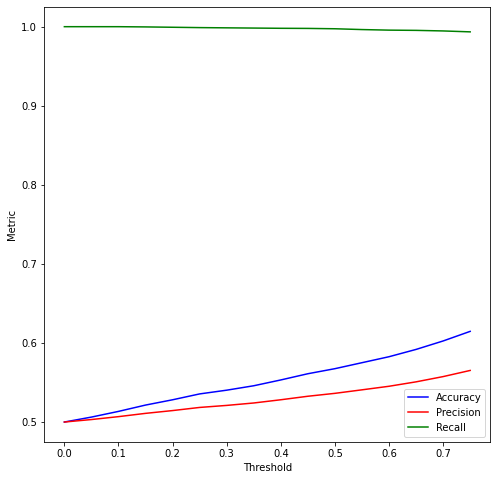

In [32]:
plt.figure(figsize=(8,8))
plt.plot(threshold_data[:,0],threshold_data[:,1],c='b',label='Accuracy')
plt.plot(threshold_data[:,0],threshold_data[:,2],c='r',label='Precision')
plt.plot(threshold_data[:,0],threshold_data[:,3],c='g',label='Recall')
plt.legend()
plt.ylabel("Metric")
plt.xlabel("Threshold")
plt.show()